## Working with time

Will adding understanding of time improve performance?

I suspect will be good at predicting but for wrong reasons - FBND and FAXS only increase in the 40-70sec time window of interest so model will just learn to increase the values with time. 

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from scipy.stats import pearsonr
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import LeakyReLU  # this is already covered by import
import random
import seaborn as sns
import sklearn
from tensorflow.keras import regularizers
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots


import pathlib
import shutil
import tempfile

from tensorflow.python.ops.gen_sparse_ops import add_many_sparse_to_tensors_map


In [3]:
def plot_loss(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.ylim([0, 1.5])
    plt.title("Training and validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Error [MAE]")
    plt.legend()
    plt.grid(True)
    plt.show()

    
def get_callbacks(name):
    return [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    ]

"""
def df_to_dataset(dataframe_X, dataframe_y, shuffle=True, batch_size=BATCH_SIZE):
    dataframe = dataframe_X.copy()
    labels = dataframe_y
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds
"""
# deal with batching
def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

def compile_and_fit(model, name, optimizer=None, max_epochs=100):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss='mean_absolute_error',
                 metrics='mean_absolute_error')

    model.summary()

    history = model.fit(
    X_train, y_train,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=(X_val, y_val),
    callbacks=get_callbacks(name),
    verbose=0)
    return history

In [17]:
mag_df = pd.read_csv("../JET_EFIT_magnetic/99070_MAGC.csv",index_col=0)

efit_df = pd.read_csv("../JET_EFIT_magnetic/99070_EFIT.csv",index_col=0)

merged_df = mag_df.merge(efit_df, how="outer",on="Time")
merged_df = merged_df.dropna(axis=0)


print(merged_df.head(2))
#merged_df = merged_df.drop(["FBND"], axis=1)


      BPME_0    BPME_1   BPME_10   BPME_11   BPME_12   BPME_13   BPME_14  \
35  0.000041  0.000129 -0.016841  0.006527 -0.017889 -0.061118 -0.011309   
36  0.000126 -0.000290 -0.000840  0.015001 -0.026383 -0.067135  0.000454   

     BPME_15   BPME_16  BPME_17  ...   FLME_38    FLME_7    FLME_8    FLME_9  \
35 -0.029960  0.005368 -0.05921  ...  0.898496 -0.023733  0.074144 -0.064945   
36 -0.057218  0.000487 -0.00163  ...  0.543274  0.005366  0.026649  0.019502   

        BVAC       FLX       IPLA   Time      FAXS      FBND  
35 -2.270235  0.001051 -242172.48  40.15 -1.116715 -1.025687  
36 -2.272149  0.001406 -236745.39  40.18 -1.123073 -1.011969  

[2 rows x 41 columns]


{'BPME_0': 0, 'BPME_1': 1, 'BPME_10': 2, 'BPME_11': 3, 'BPME_12': 4, 'BPME_13': 5, 'BPME_14': 6, 'BPME_15': 7, 'BPME_16': 8, 'BPME_17': 9, 'BPME_18': 10, 'BPME_2': 11, 'BPME_3': 12, 'BPME_4': 13, 'BPME_5': 14, 'BPME_6': 15, 'BPME_7': 16, 'BPME_8': 17, 'BPME_9': 18, 'FLME_10': 19, 'FLME_11': 20, 'FLME_12': 21, 'FLME_13': 22, 'FLME_14': 23, 'FLME_15': 24, 'FLME_16': 25, 'FLME_17': 26, 'FLME_18': 27, 'FLME_19': 28, 'FLME_20': 29, 'FLME_37': 30, 'FLME_38': 31, 'FLME_7': 32, 'FLME_8': 33, 'FLME_9': 34, 'BVAC': 35, 'FLX': 36, 'IPLA': 37, 'Time': 38, 'FAXS': 39}
648
(648, 40)


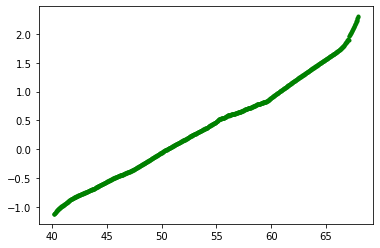

In [22]:


"""
y = pulse_data[["FAXS","FBND", "Time"]]
X = pulse_data.drop(["FAXS", "FBND"], axis=1)

#X = pulse_data.drop(["FAXS","IPLA", "FBND"], axis=1) 
# removed IPLA to have a look at normalisation plot


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=24, shuffle=False
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=24, shuffle=False
)

print(len(X_train), "train examples")
print(len(X_val), "validation examples")
print(len(X_test), "test examples")



N_VALIDATION = int(len(X_val))
N_TRAIN = int(len(X_train))
BUFFER_SIZE = N_TRAIN
BATCH_SIZE = 50 # can crank this up
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

print(X_train.head())
print(X_val.head())
print(X_test.head())

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)
"""


#follow tutorial for now
df = merged_df
column_indices = {name: i for i, name in enumerate(df.columns)}

plt.plot(
    df["Time"],
    df["FAXS"],
    color="green",
    marker=".",
)

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
print(column_indices)

#print(pulse_data.head())
print(len(train_df))
print(train_df.shape)

## Preprocessing

Note on normalising: It's arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. TODO: implement this

In [23]:
#X.describe().transpose()
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
BPME_0,927.0,-3.054423e-05,0.002033,-3.738222e-02,-1.031421e-04,0.000000e+00,9.427804e-05,0.037567
BPME_1,927.0,-2.466715e-04,0.007204,-1.518322e-01,-1.056813e-04,0.000000e+00,1.028052e-04,0.082294
BPME_10,927.0,-2.929689e-02,0.197669,-2.068179e+00,-3.221379e-02,-1.486244e-02,-5.014705e-04,1.047784
BPME_11,927.0,-2.814463e-02,0.185045,-2.068677e+00,-3.349311e-02,-1.460902e-02,-4.009934e-04,1.002500
BPME_12,927.0,-3.330437e-02,0.196459,-2.069926e+00,-3.958470e-02,-1.739825e-02,-2.052657e-04,0.985135
BPME_13,927.0,-3.754488e-02,0.196205,-2.070806e+00,-4.895848e-02,-1.927396e-02,-3.484234e-04,0.961732
BPME_14,927.0,-3.507134e-02,0.169591,-2.071686e+00,-5.514916e-02,-2.232659e-02,-2.626031e-04,0.942639
BPME_15,927.0,-4.189237e-02,0.201181,-2.072821e+00,-6.233410e-02,-2.471339e-02,-2.998979e-04,0.931517
BPME_16,927.0,-4.477263e-02,0.199780,-2.073703e+00,-6.853791e-02,-2.820191e-02,-4.442250e-04,0.930313
BPME_17,927.0,-5.155866e-02,0.197647,-2.074462e+00,-7.759429e-02,-3.109302e-02,-7.414917e-04,0.928097


In [24]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
"""
train_mean = X_train.mean()
train_std = X_train.std()

X_train = (X_train - train_mean) / train_std
X_val = (X_val - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

df_std = (X - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(X.keys(), rotation=90)
"""
train_df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
BPME_0,648.0,-2.741291e-18,1.0,-11.857112,-0.069313,-1.175325e-02,0.044049,21.790632
BPME_1,648.0,8.223874e-18,1.0,-17.718566,0.020340,3.232686e-02,0.044865,9.653433
BPME_10,648.0,1.473444e-17,1.0,-10.550513,-0.018316,6.843110e-02,0.146012,5.570825
BPME_11,648.0,3.563679e-17,1.0,-10.599362,-0.017007,7.806294e-02,0.148899,5.359879
BPME_12,648.0,4.111937e-17,1.0,-10.605930,-0.033846,7.948998e-02,0.170220,5.302165
BPME_13,648.0,-6.167906e-18,1.0,-10.603793,-0.065120,9.054113e-02,0.190316,5.206462
BPME_14,648.0,2.741291e-18,1.0,-10.389084,-0.087409,8.114607e-02,0.191556,5.007985
BPME_15,648.0,-1.370646e-17,1.0,-10.329783,-0.110955,8.722461e-02,0.210739,4.947192
BPME_16,648.0,2.741291e-18,1.0,-10.289859,-0.126555,8.799062e-02,0.225771,4.947177
BPME_17,648.0,-5.482583e-18,1.0,-10.252979,-0.148306,9.093712e-02,0.240690,4.941001


### Data windowing
We are looking at single output predictions

Not sure about single or multi timestep



In [25]:
"""
class WindowGenerator:
    def __init__(
        self,
        input_width,
        label_width,
        shift,
        X_train=X_train,
        X_val=X_val,
        X_test=X_test,
        label_columns=None,
    ):
    # Store the raw data.
        self.X_train = X_train
        self.X_val = X_val
        self.X_test = X_test

    # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(X_train.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return "\n".join(
            [
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Label column name(s): {self.label_columns}",
            ]
        )
"""
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

    # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return "\n".join(
            [
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Label column name(s): {self.label_columns}",
            ]
        )
    

In [26]:
def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

In [27]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['FAXS'])
WindowGenerator.split_window = split_window
print(df.columns)

Index(['BPME_0', 'BPME_1', 'BPME_10', 'BPME_11', 'BPME_12', 'BPME_13',
       'BPME_14', 'BPME_15', 'BPME_16', 'BPME_17', 'BPME_18', 'BPME_2',
       'BPME_3', 'BPME_4', 'BPME_5', 'BPME_6', 'BPME_7', 'BPME_8', 'BPME_9',
       'FLME_10', 'FLME_11', 'FLME_12', 'FLME_13', 'FLME_14', 'FLME_15',
       'FLME_16', 'FLME_17', 'FLME_18', 'FLME_19', 'FLME_20', 'FLME_37',
       'FLME_38', 'FLME_7', 'FLME_8', 'FLME_9', 'BVAC', 'FLX', 'IPLA', 'Time',
       'FAXS'],
      dtype='object')


In [28]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

w2.example = example_inputs, example_labels

All shapes are: (batch, time, features)
Window shape: (3, 7, 40)
Inputs shape: (3, 6, 40)
labels shape: (3, 1, 1)


In [29]:
def plot(self, model=None, plot_col='FAXS', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
        plt.legend()

    plt.xlabel('Batches (roughly 7 seconds)')
    
WindowGenerator.plot = plot

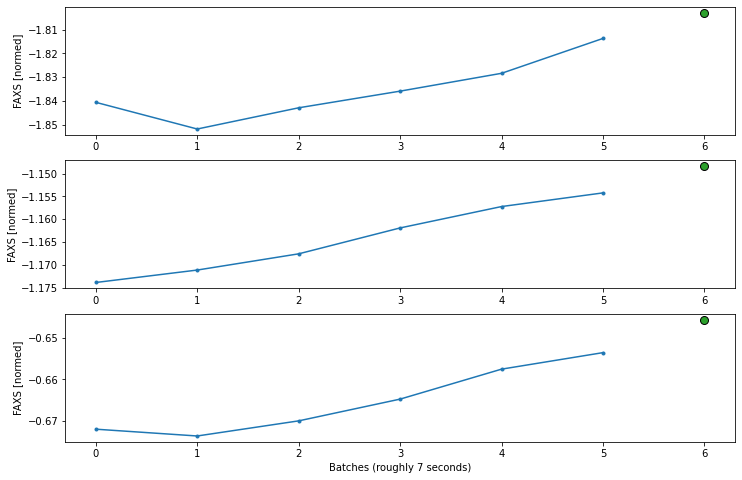

In [30]:
w2.plot()


### Convert to tf.Dataset

In [118]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [119]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
    # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
    # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

#### Single step model

In [120]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['FAXS'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['FAXS']

In [121]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 1, 40)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline


In [122]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]


In [123]:
baseline = Baseline(label_index=column_indices['FAXS'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)


6/6 [==============================] - 0s 800us/step - loss: 5.4812e-05 - mean_absolute_error: 0.0072


In [124]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['FAXS'])


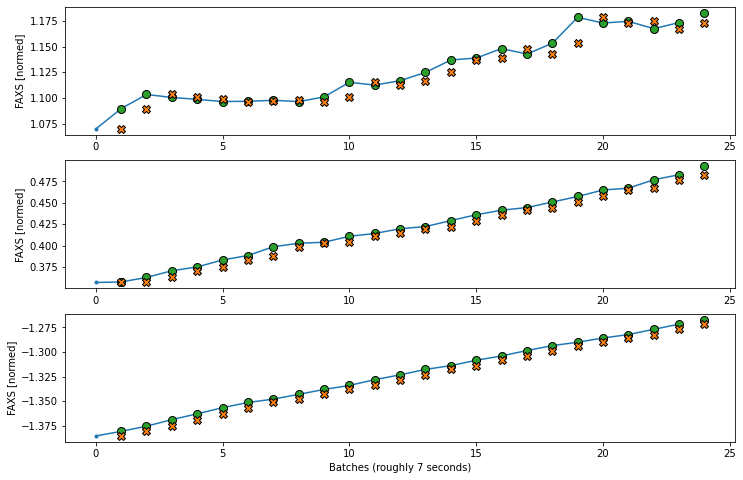

In [125]:
wide_window.plot(baseline)


The wide_window doesn't change the way the model operates. The model still makes predictions 1h into the future based on a single input time step. The time axis acts like the batch axis- each prediction is made independently with no interaction between time steps.

Baselines predictions is just the labels offset by one timestep

Fix x-axis here

In [126]:
#print(train_df.head())
#print(pulse_data.head(-3))
#print(df.columns)
print(train_df.head(-2))


         FAXS       Time    BPME_1   FLME_12   BPME_12   FLME_14   FLME_17  \
0   -1.116715  40.150002  0.000129 -0.122133 -0.017889 -0.304657 -0.013013   
1   -1.123073  40.180000 -0.000290 -0.142496 -0.026383  0.085745 -0.004950   
2   -1.118021  40.209999 -0.000083  0.053639 -0.039445  0.019529  0.098409   
3   -1.114052  40.240002  0.000035  0.068133 -0.049127  0.076016  0.064381   
4   -1.109803  40.270000 -0.000034  0.151354 -0.047392  0.084846 -0.216641   
..        ...        ...       ...       ...       ...       ...       ...   
641  0.817297  59.380001  0.000051  0.000025 -0.014082  0.070409 -0.063735   
642  0.820010  59.410000 -0.000203 -0.060395 -0.019945  0.163247 -0.015605   
643  0.822459  59.439999 -0.000152 -0.081009 -0.028834  0.058387 -0.000735   
644  0.824133  59.470001  0.000162 -0.080415 -0.042759  0.038370  0.106804   
645  0.826247  59.500000 -0.000314 -0.060097 -0.053200 -0.040362  0.063073   

       BPME_5   FLME_13    FLME_7  ...   FLME_15   FLME_38   BP

In [129]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

### Linear model

In [128]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)


Input shape: (32, 1, 40)
Output shape: (32, 1, 1)


In [130]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)


Epoch 1/20
21/21 [==============================] - 1s 7ms/step - loss: 1.5376 - mean_absolute_error: 0.9533 - val_loss: 8.8658 - val_mean_absolute_error: 2.5968
Epoch 2/20
21/21 [==============================] - 0s 6ms/step - loss: 1.4002 - mean_absolute_error: 0.9065 - val_loss: 8.1066 - val_mean_absolute_error: 2.4862
Epoch 3/20
21/21 [==============================] - 0s 3ms/step - loss: 1.2778 - mean_absolute_error: 0.8635 - val_loss: 7.3476 - val_mean_absolute_error: 2.3687
Epoch 4/20
21/21 [==============================] - 0s 4ms/step - loss: 1.1635 - mean_absolute_error: 0.8211 - val_loss: 6.6255 - val_mean_absolute_error: 2.2524
Epoch 5/20
21/21 [==============================] - 0s 3ms/step - loss: 1.0600 - mean_absolute_error: 0.7814 - val_loss: 5.9170 - val_mean_absolute_error: 2.1313
Epoch 6/20
21/21 [==============================] - 0s 3ms/step - loss: 0.9643 - mean_absolute_error: 0.7433 - val_loss: 5.3111 - val_mean_absolute_error: 2.0228
Epoch 7/20
21/21 [==========

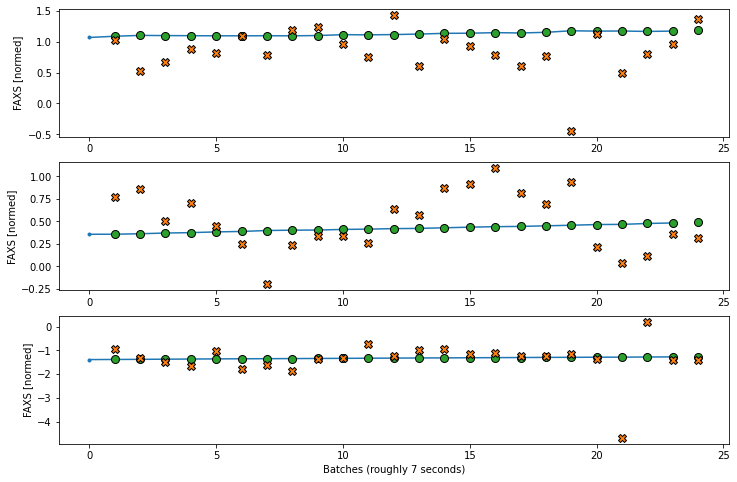

In [131]:
wide_window.plot(linear)


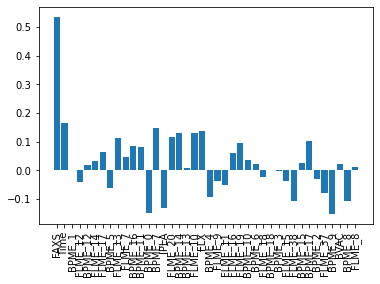

In [132]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)


It's relying on time and previous FAXS values... what happens when we take that away?

In [133]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)


Epoch 1/20
21/21 [==============================] - 1s 10ms/step - loss: 0.9104 - mean_absolute_error: 0.7724 - val_loss: 3.5388 - val_mean_absolute_error: 1.7811
Epoch 2/20
21/21 [==============================] - 0s 4ms/step - loss: 0.2504 - mean_absolute_error: 0.3984 - val_loss: 2.2789 - val_mean_absolute_error: 1.3407
Epoch 3/20
21/21 [==============================] - 0s 3ms/step - loss: 0.1239 - mean_absolute_error: 0.2833 - val_loss: 1.5993 - val_mean_absolute_error: 1.0864
Epoch 4/20
21/21 [==============================] - 0s 4ms/step - loss: 0.0739 - mean_absolute_error: 0.2140 - val_loss: 1.1770 - val_mean_absolute_error: 0.8971
Epoch 5/20
21/21 [==============================] - 0s 3ms/step - loss: 0.0493 - mean_absolute_error: 0.1744 - val_loss: 1.0465 - val_mean_absolute_error: 0.8328
Epoch 6/20
21/21 [==============================] - 0s 3ms/step - loss: 0.0371 - mean_absolute_error: 0.1488 - val_loss: 0.9692 - val_mean_absolute_error: 0.7870
Epoch 7/20
21/21 [=========

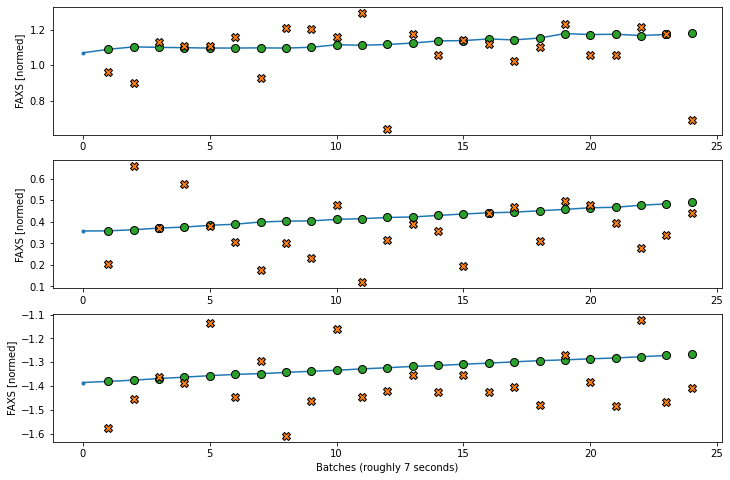

In [134]:
wide_window.plot(dense)

The dense network was worse??

# Does adding more than one pulse help or hinder?

In [70]:
mag_df2 = pd.read_csv("../JET_EFIT_magnetic/99071_MAGC.csv",index_col=0)

efit_df2 = pd.read_csv("../JET_EFIT_magnetic/99071_EFIT.csv",index_col=0)

merged_df2 = mag_df2.merge(efit_df2, how="outer",on="Time")
merged_df2 = merged_df2.dropna(axis=0)


print(merged_df2.head(2))
merged_df2 = merged_df2.drop(["FBND"], axis=1)


      BPME_0    BPME_1   BPME_10   BPME_11   BPME_12   BPME_13   BPME_14  \
34  0.000206  0.000295 -0.000772  0.002626 -0.012219 -0.040864 -0.010054   
35 -0.000314 -0.000047 -0.016948  0.007018 -0.017466 -0.060956 -0.009824   

     BPME_15   BPME_16   BPME_17  ...   FLME_38    FLME_7    FLME_8    FLME_9  \
34 -0.020715 -0.001754 -0.076923  ...  0.809941 -0.009351 -0.000732 -0.040903   
35 -0.029548  0.007634 -0.059933  ...  0.893625 -0.023933  0.074038 -0.065591   

        BVAC       FLX       IPLA   Time     FAXS      FBND  
34 -2.265028  0.000835 -259613.36  40.12 -1.10228 -1.035465  
35 -2.268187  0.001105 -243930.11  40.15 -1.11684 -1.027428  

[2 rows x 41 columns]


In [71]:
two_pulse = merged_df.append(merged_df2)

print(merged_df.shape)
print(merged_df2.shape)

print(two_pulse.shape)

print(two_pulse.head(2))

#two_pulse = two_pulse.drop(["FAXS"], axis=1)

print(two_pulse.head(2))

(927, 41)
(929, 40)
(1856, 41)
      BPME_0    BPME_1   BPME_10   BPME_11   BPME_12   BPME_13   BPME_14  \
35  0.000041  0.000129 -0.016841  0.006527 -0.017889 -0.061118 -0.011309   
36  0.000126 -0.000290 -0.000840  0.015001 -0.026383 -0.067135  0.000454   

     BPME_15   BPME_16  BPME_17  ...   FLME_38    FLME_7    FLME_8    FLME_9  \
35 -0.029960  0.005368 -0.05921  ...  0.898496 -0.023733  0.074144 -0.064945   
36 -0.057218  0.000487 -0.00163  ...  0.543274  0.005366  0.026649  0.019502   

        BVAC       FLX       IPLA   Time      FAXS      FBND  
35 -2.270235  0.001051 -242172.48  40.15 -1.116715 -1.025687  
36 -2.272149  0.001406 -236745.39  40.18 -1.123073 -1.011969  

[2 rows x 41 columns]
      BPME_0    BPME_1   BPME_10   BPME_11   BPME_12   BPME_13   BPME_14  \
35  0.000041  0.000129 -0.016841  0.006527 -0.017889 -0.061118 -0.011309   
36  0.000126 -0.000290 -0.000840  0.015001 -0.026383 -0.067135  0.000454   

     BPME_15   BPME_16  BPME_17  ...   FLME_38    FLME_7  

In [72]:
y = merged_df["FAXS"]
X = merged_df.drop(["FAXS", "FBND","Time"], axis=1)

#X = pulse_data.drop(["FAXS","IPLA", "FBND"], axis=1) 
# removed IPLA to have a look at normalisation plot


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=24
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=24
)

print(len(X_train), "train examples")
print(len(X_val), "validation examples")
print(len(X_test), "test examples")

592 train examples
149 validation examples
186 test examples


In [73]:
"""
pulse_data = pd.read_csv("../JET_EFIT_magnetic/interpolated_99070.csv")
pulse_data = pulse_data.dropna(axis=0)
"""
y2 = two_pulse["FAXS"]
X2 = two_pulse.drop(["FAXS", "FBND", "Time"], axis=1)

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y2, test_size=0.2, random_state=24
)

X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X_train2, y_train2, test_size=0.2, random_state=24
)

print(len(X_train2), "train examples")
print(len(X_val2), "validation examples")
print(len(X_test2), "test examples")


1187 train examples
297 validation examples
372 test examples


### One pulse:

In [74]:

N_VALIDATION = int(len(X_val))
N_TRAIN = int(len(X_train))
BUFFER_SIZE = N_TRAIN
BATCH_SIZE = 50 # can crank this up
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE



lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

def compile_and_fit(model, name, optimizer=None, max_epochs=100):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss='mean_absolute_error',
                 metrics='mean_absolute_error')

    model.summary()

    history = model.fit(
    X_train, y_train,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=(X_val, y_val),
    callbacks=get_callbacks(name),
    verbose=0)
    return history

In [75]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))
print(normalizer.mean.numpy())

# figure out memory efficient read in

[ 2.3767650e-06 -4.7574143e-04 -3.2266594e-02 -2.8110569e-02
 -3.2766439e-02 -3.7593283e-02 -3.6562696e-02 -4.1417826e-02
 -4.4736523e-02 -4.9843192e-02 -5.6632172e-02 -1.3400409e-03
 -1.0451783e-03  2.1148766e-03  1.1418740e-02 -6.0083863e-04
  1.2562006e-02  2.5112419e-03 -2.0918988e-02 -2.4021726e-02
 -2.6293665e-02 -2.1949312e-02 -2.1788437e-02 -1.3369092e-02
 -1.9232241e-02 -1.1121899e-02 -1.0476898e-02 -8.6549986e-03
 -8.0897454e-03 -6.0594669e-03  2.5254289e-02  2.0997068e-02
 -2.6153300e-02 -2.5028795e-02 -2.3406498e-02 -2.3329859e+00
  6.0952120e-02 -1.7627329e+06]


In [76]:
pulsenum_histories = {}


attempt_l2_dropout = tf.keras.Sequential([
    normalizer,
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, 
                 kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dropout(0.01),
    layers.Dense(1)
])

pulsenum_histories['one_pulse'] = compile_and_fit(attempt_l2_dropout, "pulses/one_pulse")


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 38)                77        
_________________________________________________________________
dense_40 (Dense)             (None, 512)               19968     
_________________________________________________________________
dense_41 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_42 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_43 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 1)                

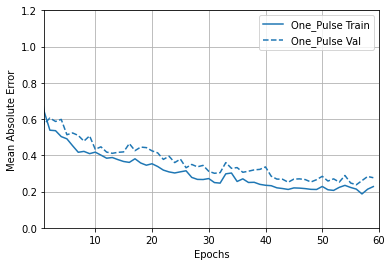

In [77]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')

plotter.plot(pulsenum_histories)
plt.ylim([0, 1.2])
plt.xlim([1, 60])
plt.legend(loc="upper right")

### Two pulse

In [78]:
normalizer2 = preprocessing.Normalization(axis=-1)
normalizer2.adapt(np.array(X_train2))
print(normalizer.mean.numpy())

N_VALIDATION = int(len(X_val2))
N_TRAIN = int(len(X_train2))
BUFFER_SIZE = N_TRAIN
BATCH_SIZE = 50 # can crank this up
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE



[ 2.3767650e-06 -4.7574143e-04 -3.2266594e-02 -2.8110569e-02
 -3.2766439e-02 -3.7593283e-02 -3.6562696e-02 -4.1417826e-02
 -4.4736523e-02 -4.9843192e-02 -5.6632172e-02 -1.3400409e-03
 -1.0451783e-03  2.1148766e-03  1.1418740e-02 -6.0083863e-04
  1.2562006e-02  2.5112419e-03 -2.0918988e-02 -2.4021726e-02
 -2.6293665e-02 -2.1949312e-02 -2.1788437e-02 -1.3369092e-02
 -1.9232241e-02 -1.1121899e-02 -1.0476898e-02 -8.6549986e-03
 -8.0897454e-03 -6.0594669e-03  2.5254289e-02  2.0997068e-02
 -2.6153300e-02 -2.5028795e-02 -2.3406498e-02 -2.3329859e+00
  6.0952120e-02 -1.7627329e+06]


In [79]:
attempt_l2_dropout_multipulse = tf.keras.Sequential([
    normalizer2,
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, 
                 kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dropout(0.01),
    layers.Dense(1)
])

pulsenum_histories['two_pulse'] = compile_and_fit(attempt_l2_dropout_multipulse, "pulses/two_pulse")


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_6 (Normalizati (None, 38)                77        
_________________________________________________________________
dense_45 (Dense)             (None, 512)               19968     
_________________________________________________________________
dense_46 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_47 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_48 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 1)                

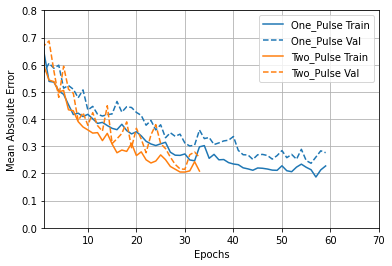

In [80]:
plotter.plot(pulsenum_histories)
plt.ylim([0, 0.8])
plt.xlim([1, 70])
plt.legend(loc="upper right")

Text(0.5, 0, 'Epochs [Log Scale]')

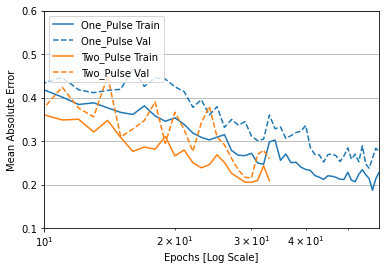

In [81]:
plotter.plot(pulsenum_histories)
a = plt.xscale('log')
plt.xlim([10, max(plt.xlim())])
#plt.xlim([1, 100])
plt.legend(loc="upper left")
plt.ylim([0.1, 0.6])
plt.xlabel("Epochs [Log Scale]")


### One pulse results:

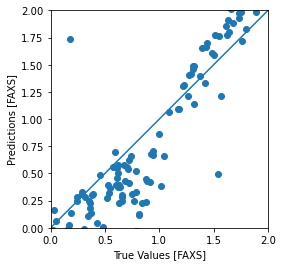

In [82]:
y_pred = attempt_l2_dropout.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values [FAXS]')
plt.ylabel('Predictions [FAXS]')
lims = [0, 2]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

### Two pulse results:

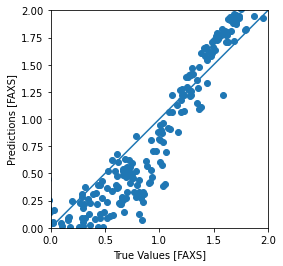

In [83]:
y_pred2 = attempt_l2_dropout.predict(X_test2).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test2, y_pred2)
plt.xlabel('True Values [FAXS]')
plt.ylabel('Predictions [FAXS]')
lims = [0, 2]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

### Two pulse with same num of data points as one (for direct comparison):

In [84]:
#X_train2, X_val2, y_train2, y_val2 = train_test_split(
#    X_train2, y_train2, test_size=0.2, random_state=24
#)

X_train3 = X_train2[0:(len(X_train))]
X_val3 = X_val2[0:(len(X_val))]
X_test3 = X_test2[0:(len(X_test))]


y_train3 = y_train2[0:(len(y_train))]
y_val3 = y_val2[0:(len(y_val))]
y_test3 = y_test2[0:(len(y_test))]



print(len(X_train3), "train examples")
print(len(X_val3), "validation examples")
print(len(X_test3), "test examples")


print(len(X_train), "train examples")
print(len(X_val), "validation examples")
print(len(X_test), "test examples")

592 train examples
149 validation examples
186 test examples
592 train examples
149 validation examples
186 test examples


In [85]:
normalizer3 = preprocessing.Normalization(axis=-1)
normalizer3.adapt(np.array(X_train3))
print(normalizer3.mean.numpy())

N_VALIDATION = int(len(X_val3))
N_TRAIN = int(len(X_train3))
BUFFER_SIZE = N_TRAIN
BATCH_SIZE = 50 # can crank this up
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

[ 2.04874705e-05 -6.55004114e-04 -2.66383532e-02 -3.06054335e-02
 -2.48282198e-02 -4.47425433e-02 -3.48261446e-02 -3.63515690e-02
 -5.36453724e-02 -5.74323870e-02 -5.46000674e-02 -8.14389845e-04
  1.22237892e-04 -1.04517945e-04  1.16498610e-02  1.71130206e-02
  1.18148439e-02 -3.14488402e-03 -2.24017464e-02 -2.89650969e-02
 -1.88417882e-02 -2.20393352e-02 -1.61505230e-02 -2.37164367e-02
 -2.22635455e-02 -1.60708204e-02 -1.04546854e-02 -8.69498588e-03
 -7.21318042e-03 -8.27388745e-03  3.09524126e-02  1.60184950e-02
 -2.29580346e-02 -2.13421378e-02 -2.00896449e-02 -2.33937454e+00
  5.99884130e-02 -1.74290188e+06]


In [91]:
attempt_l2_dropout_compare = tf.keras.Sequential([
    normalizer3,
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, 
                 kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dropout(0.01),
    layers.Dense(1)
])

pulsenum_histories['two_pulse_compare'] = compile_and_fit(attempt_l2_dropout_compare, "pulses/two_pulse_compare")

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_7 (Normalizati (None, 38)                77        
_________________________________________________________________
dense_55 (Dense)             (None, 512)               19968     
_________________________________________________________________
dense_56 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_57 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_58 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 1)               

(1.0, 59.0)

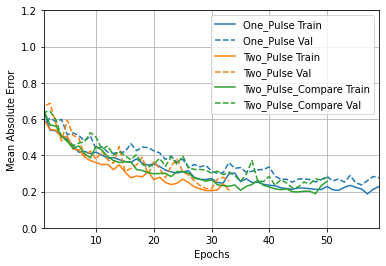

In [92]:
plotter.plot(pulsenum_histories)
plt.ylim([0, 1.2])
plt.xlim([1, max(plt.xlim())])

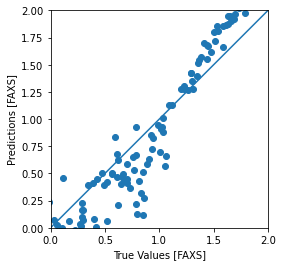

In [93]:
y_pred3 = attempt_l2_dropout_compare.predict(X_test3).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test3, y_pred3)
plt.xlabel('True Values [FAXS]')
plt.ylabel('Predictions [FAXS]')
lims = [0, 2]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Text(0.5, 0, 'Epochs [Log Scale]')

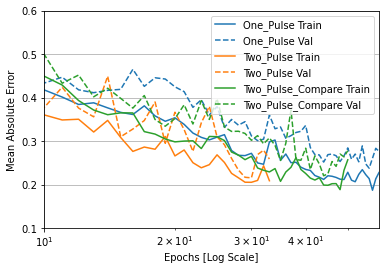

In [97]:
plotter.plot(pulsenum_histories)
a = plt.xscale('log')
plt.xlim([10, max(plt.xlim())])
#plt.xlim([1, 100])
plt.legend(loc="upper right")
plt.ylim([0.1, 0.6])
plt.xlabel("Epochs [Log Scale]")
